# Time Stamp Extract

Brief 1-2 sentence description of notebook.

- Notebook that extracts the timestamps and gets the time that tones played

In [5]:
# Imports of all used packages and libraries
import os
import sys
import glob
from collections import defaultdict

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# setting path
sys.path.append('../../src')

In [8]:
import trodes.read_exported

## Inputs & Data

- Explanation of each input and where it comes from.

Inputs and Required data loading
- input variable names are in all caps snake case
- Whenever an input changes or is used for processing 
- The variables are all lower in snake case

In [9]:
# Path of the directory that contains the Spike Gadgets recording and the exported timestamp files
# Exported with this tool https://docs.spikegadgets.com/en/latest/basic/ExportFunctions.html
# Export these files:
    # -raw – Continuous raw band export.
    # -dio – Digital IO channel state change export.
    # -analogio – Continuous analog IO export.
INPUT_DIR = "/scratch/back_up/reward_competition_extention/data"
INPUT_GLOB = "/scratch/back_up/reward_competition_extention/data/*/*/*.rec"
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
TONE_DIN = "dio_ECU_Din1"
TONE_STATE = 1
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "pilot2"

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Other documentation

raw directory
- raw_group0.dat
    - voltage_value: Array with voltage measurement for each channel at each timestamp
- timestamps.dat
    - voltage_time_stamp: The time stamp of each voltage measurement

parent directory
- 1.videoTimeStamps.cameraHWSync
    - frame_number: Calculated by getting the index of each video time stamp tuple 
    - PosTimestamp: The time stamp of each video frame
    - HWframeCount: Unknown value. Starts at 30742 and increases by 1 for each tuple  
    - HWTimestamp: Unknown value. All zeroes
    - video_time: Calculated by dividing the frame number by the fps(frames per second) 
    - video_seconds: video_time, but rounded to seconds  	
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_PosTimestamp 	
        - filledHWframeCount 	
        - filled_frame_number 	
        - filled_video_time 	
        - filled_video_seconds 	

DIO directory
- dio_ECU_Din1.dat
    - time: The time stamp the corresponds to the DIN input
    - state: Binary state of whether there is input from DIN or not 	
    - trial_number: Calculated by adding 1 to every time there is a DIN input
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_state 	
        - filled_trial_number

ss_output directory (Spike sorting with Spike interface)
- firings.npz
    - unit_id: All the units that had a spike train for the given timestamp 	
    - number_of_units: Calculated by counting the number of units that had a spike train

## Functions

- function names are short and in snake case all lowercase
- a function name should be unique but does not have to describe the function
- doc strings describe functions not function names

In [6]:
def find_closest_index(sorted_list=None, target=0):
    """
    Returns the index of the number in the sorted list that is closest to the target.

    This function performs a binary search on a sorted list to find the closest number to 
    a given target. If the target exists in the list, its index is returned. If not, the 
    function will return the index of the number that's closest to the target.

    Parameters:
    - sorted_list (list[int or float]): A sorted list of numbers.
    - target (int or float): The target number to find the closest value to.

    Returns:
    - int: The index of the closest number in the sorted list to the target. 
           If the sorted list is empty, returns None.

    Example:
    >>> sorted_nums = [1, 3, 5, 8, 10, 15, 18, 20, 24, 27, 30]
    >>> find_closest_index(sorted_nums, 6)
    2

    Note:
    The list should be sorted in ascending order.
    """
    
    if sorted_list is None:
        return None
    if target <= sorted_list[0]:
        return 0
    if target >= sorted_list[-1]:
        return len(sorted_list) - 1

    # Binary search
    left, right = 0, len(sorted_list) - 1
    while left <= right:
        mid = (left + right) // 2

        if sorted_list[mid] == target:
            return mid
        elif sorted_list[mid] < target:
            left = mid + 1
        else:
            right = mid - 1

    # After binary search, the target will be between sorted_list[right] and sorted_list[left]
    # We compare the two to see which one is closer to the target and return its index
    if abs(sorted_list[left] - target) < abs(sorted_list[right] - target):
        return left
    else:
        return right

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [7]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

In [8]:
all_session_files = glob.glob(INPUT_GLOB)

In [9]:
all_session_files

['/scratch/back_up/reward_competition_extention/data/novel_agent/2023_06_29/20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2.rec',
 '/scratch/back_up/reward_competition_extention/data/novel_agent/2023_06_30/20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs2-1and1-2vs2-2.rec',
 '/scratch/back_up/reward_competition_extention/data/novel_agent/2023_06_28/20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1.rec',
 '/scratch/back_up/reward_competition_extention/data/standard/2023_06_14/20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.rec',
 '/scratch/back_up/reward_competition_extention/data/standard/2023_06_14/20230614_115827_standard_comp_to_training_D3_subj_2-1_and_2-4.rec',
 '/scratch/back_up/reward_competition_extention/data/standard/2023_06_13/20230613_110126_standard_comp_to_training_D2_subj_2-4_and_2-2.rec',
 '/scratch/back_up/reward_competition_extention/data/standard/2023_06_13/20230613_105657_standard_comp_to_traini

# LOOP 1: Extracting all the Trodes

- Getting all the data from all the exported Trodes files

In [10]:
session_to_dir = {}
session_to_path = {}
# Going through each session recording
# Which includes all the recordings from all the miniloggers and cameras
for session_path in all_session_files:   
    try:
        session_basename = os.path.splitext(os.path.basename(session_path))[0]
        print("Current Session: {}".format(session_basename))
        session_to_dir[session_basename] = trodes.read_exported.organize_all_trodes_export(session_path)
        session_to_path[session_basename] = session_path
    except Exception as e: 
        print(e)


Current Session: 20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2
Skipping file 20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1v1-4and2-1_merged.timestampoffset.txt due to error: Settings format not supported


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Current Session: 20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs2-1and1-2vs2-2
Skipping file 20230630_115506_standard_comp_to_novel_agent_D3_subj_1-2vs1-4and2-2_merged.timestampoffset.txt due to error: Settings format not supported
Current Session: 20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1
Skipping file 20230628_111202_standard_comp_to_novel_agent_D1_subj_1-2vs1-1and2-1_merged.timestampoffset.txt due to error: Settings format not supported
Skipping file 20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs1-2and2-2_merged.timestampoffset.txt due to error: Settings format not supported
Current Session: 20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2
Skipping file 20230614_114041_standard_comp_to_training_D3_subj_1-2_t2b2L_box2_merged.timestampoffset.txt due to error: Settings format not supported
Skipping file 20230614_114041_standard_comp_to_training_D3_subj_1-1_t1b3L_box1_merged.timestampoffset.txt due to error: Settings for

# LOOP 2: Extracting the timestamps for the raw ephys recording

20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1v1-4and2-1_merged
dio_ECU_Din4


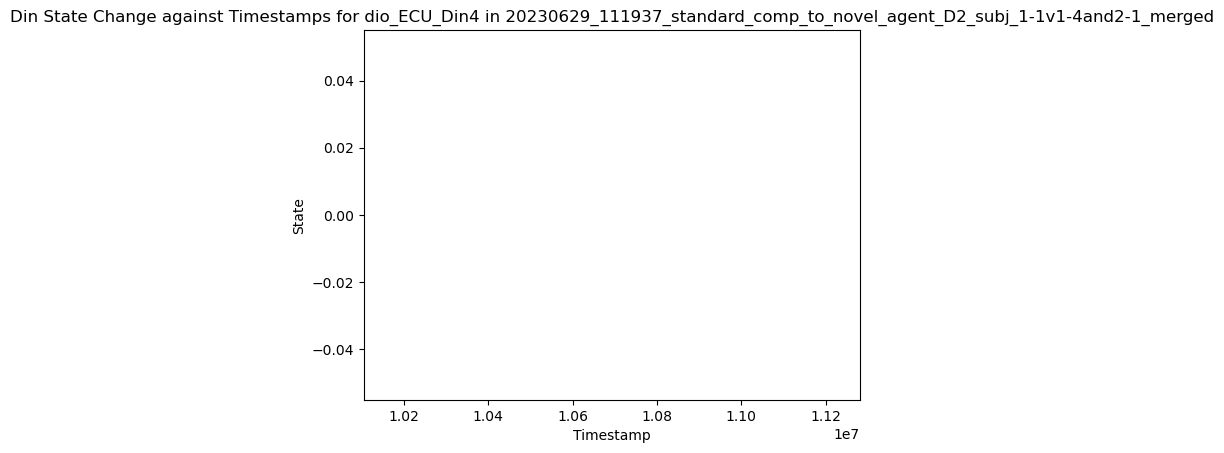

dio_ECU_Din2


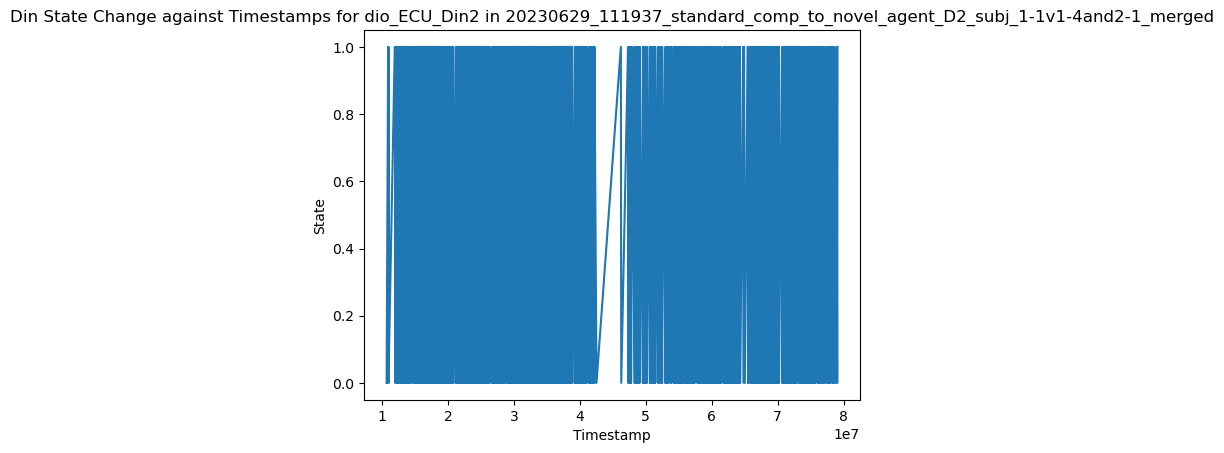

dio_ECU_Din3


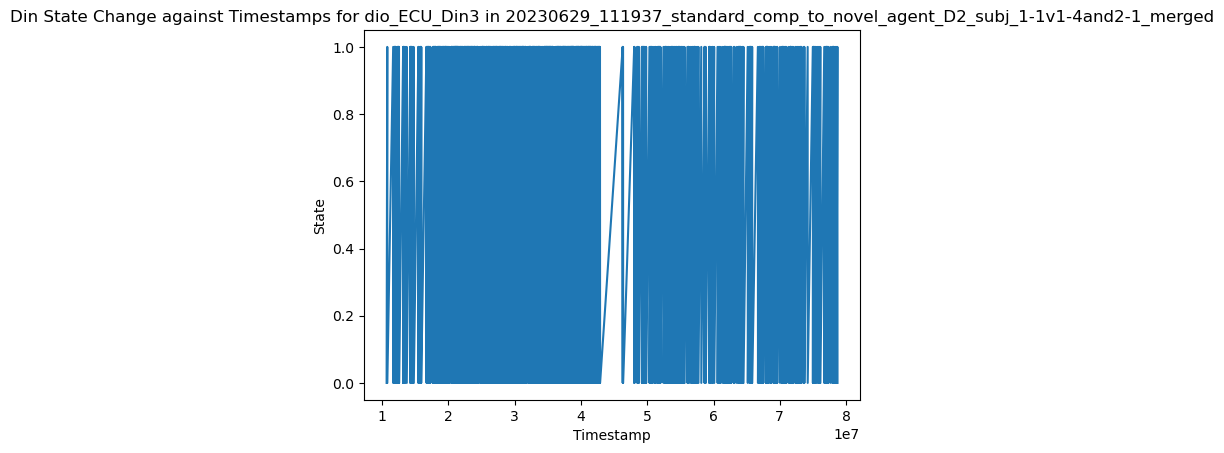

dio_ECU_Din1


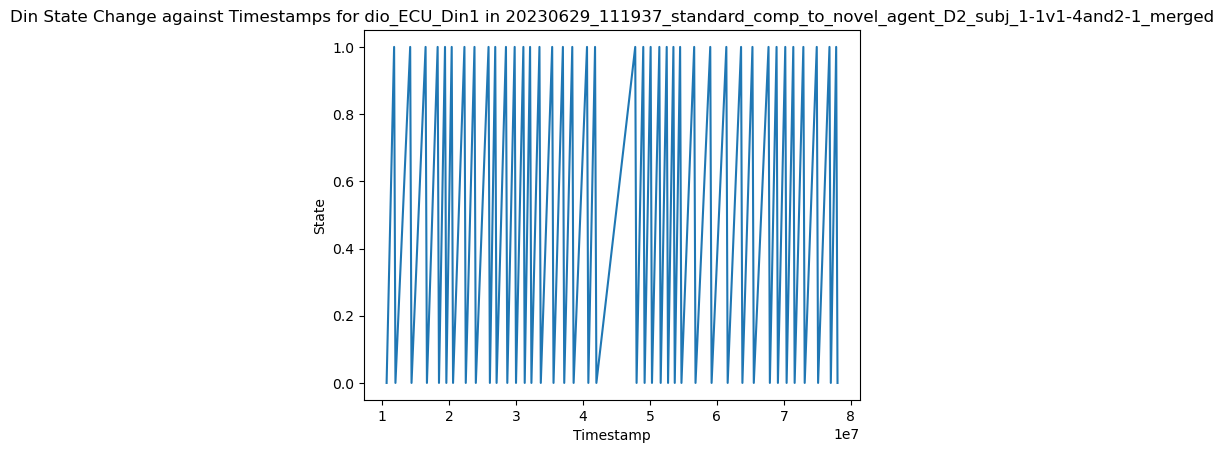

20230630_115506_standard_comp_to_novel_agent_D3_subj_1-2vs1-4and2-2_merged
dio_ECU_Din2


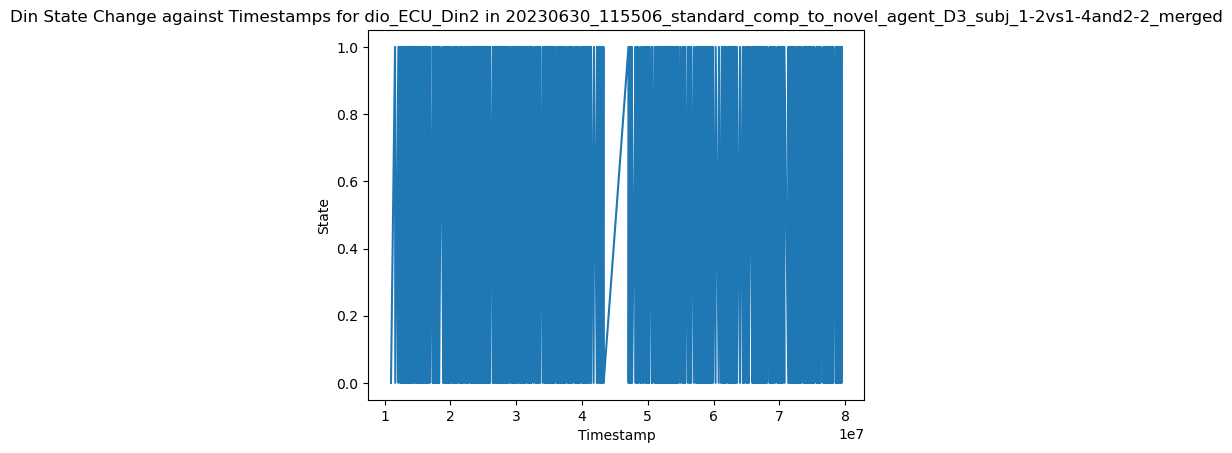

dio_ECU_Din1


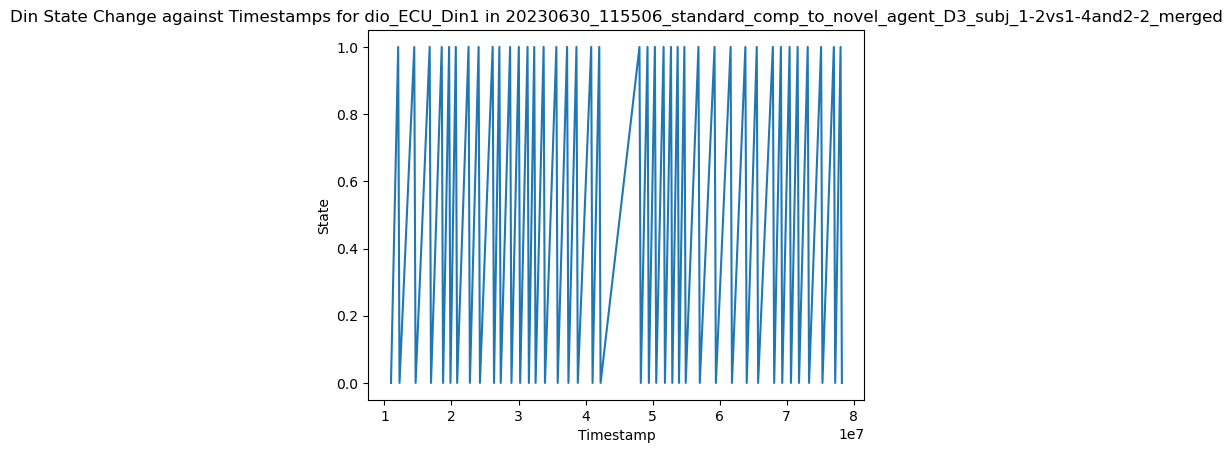

dio_ECU_Din4


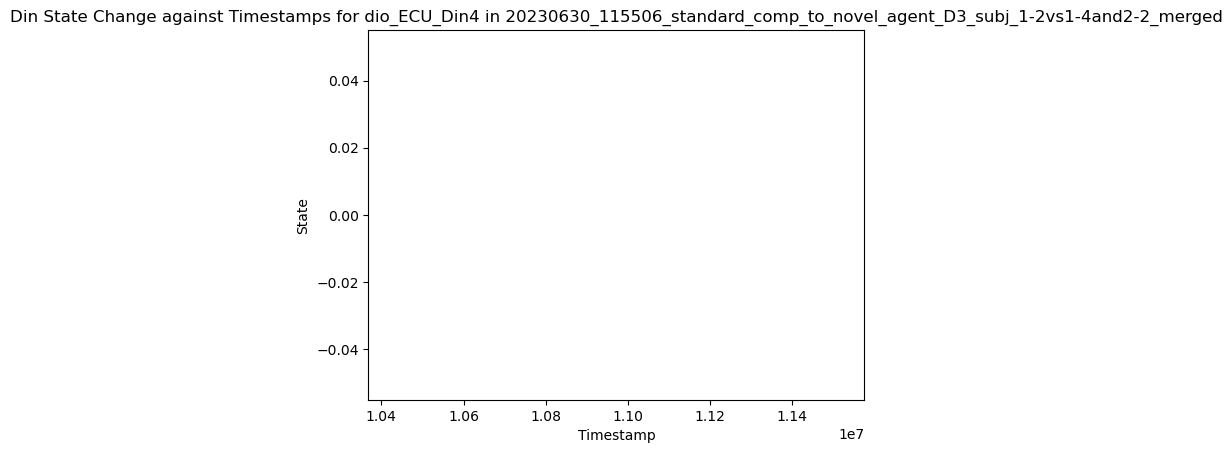

dio_ECU_Din3


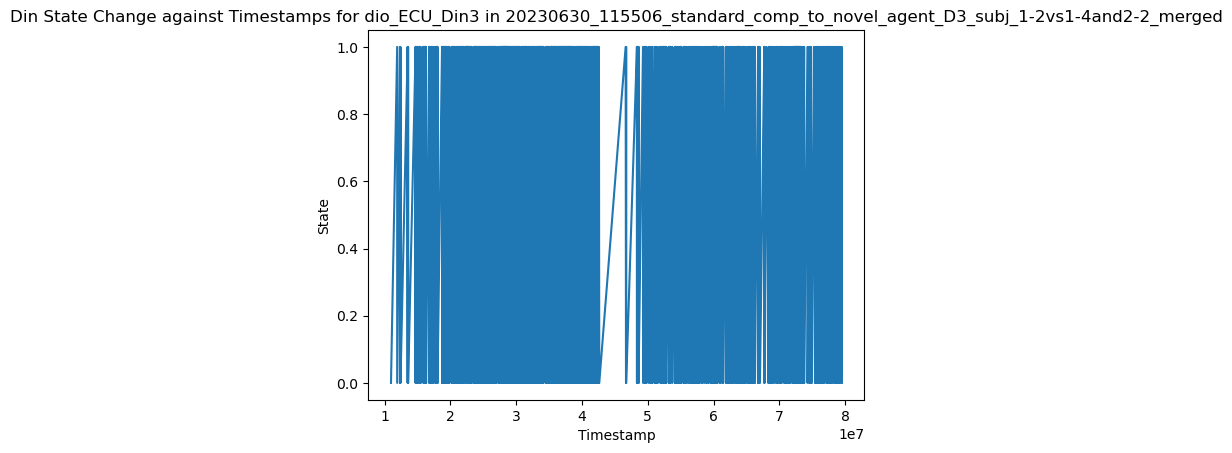

20230628_111202_standard_comp_to_novel_agent_D1_subj_1-2vs1-1and2-1_merged
dio_ECU_Din2


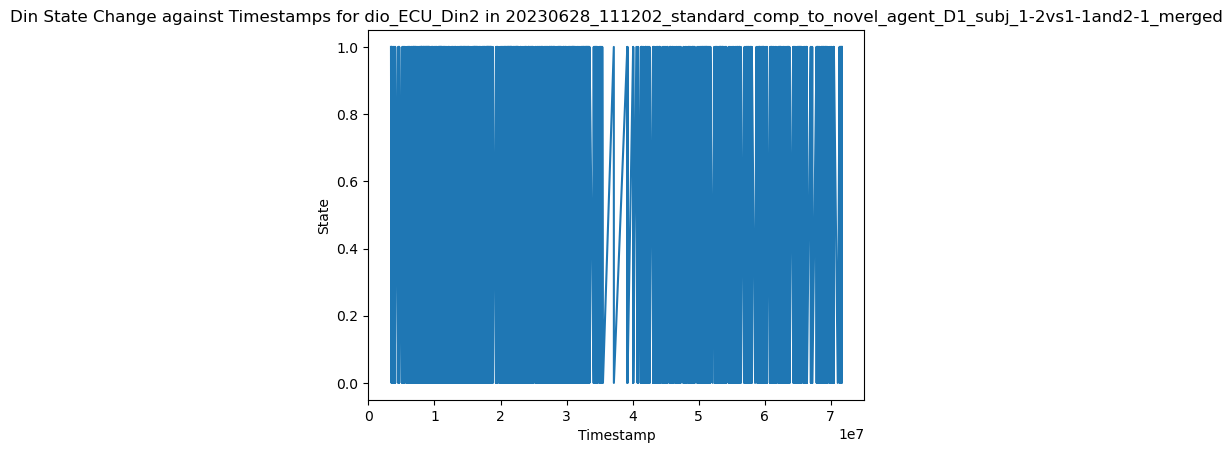

dio_ECU_Din1


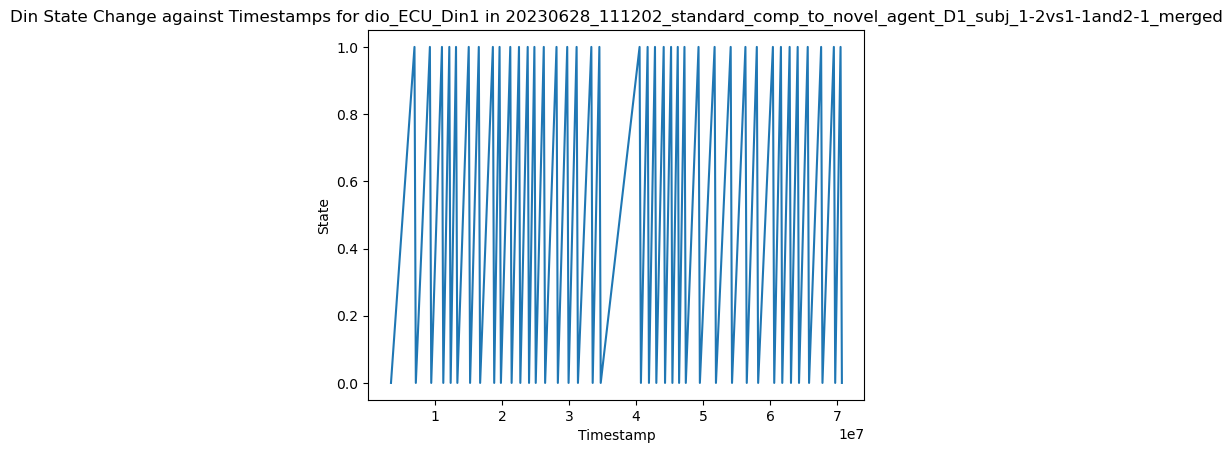

dio_ECU_Din4


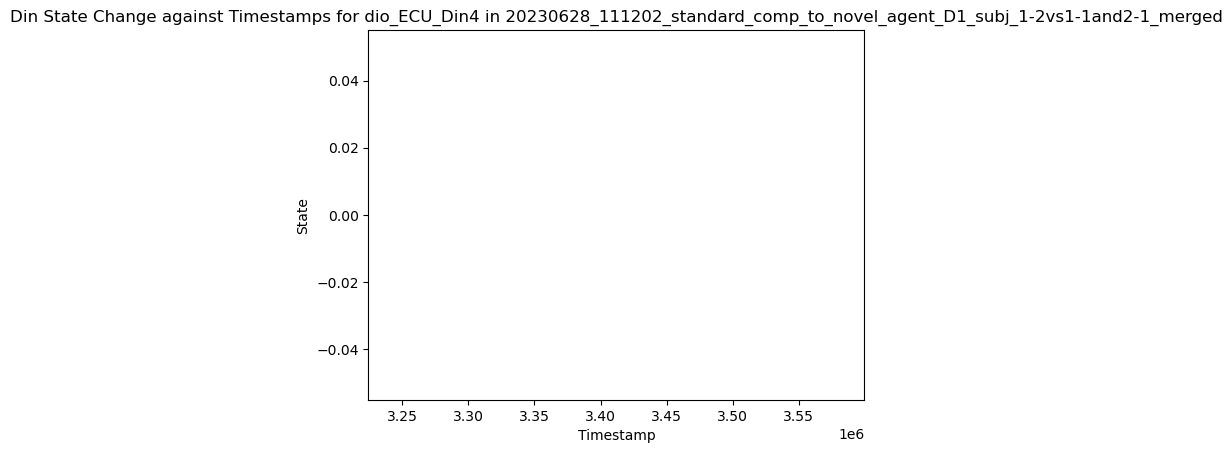

dio_ECU_Din3


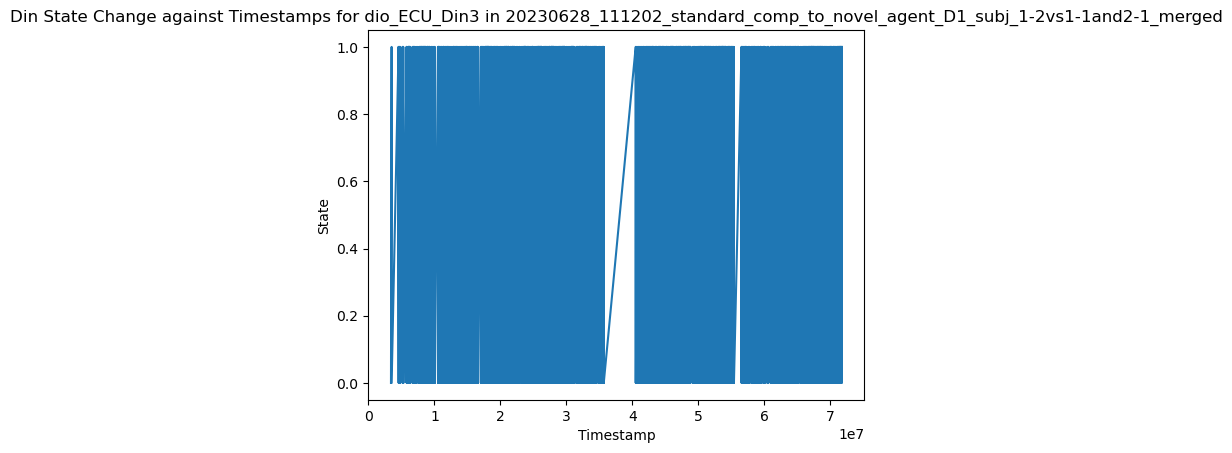

20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs1-2and2-2_merged
dio_ECU_Din2


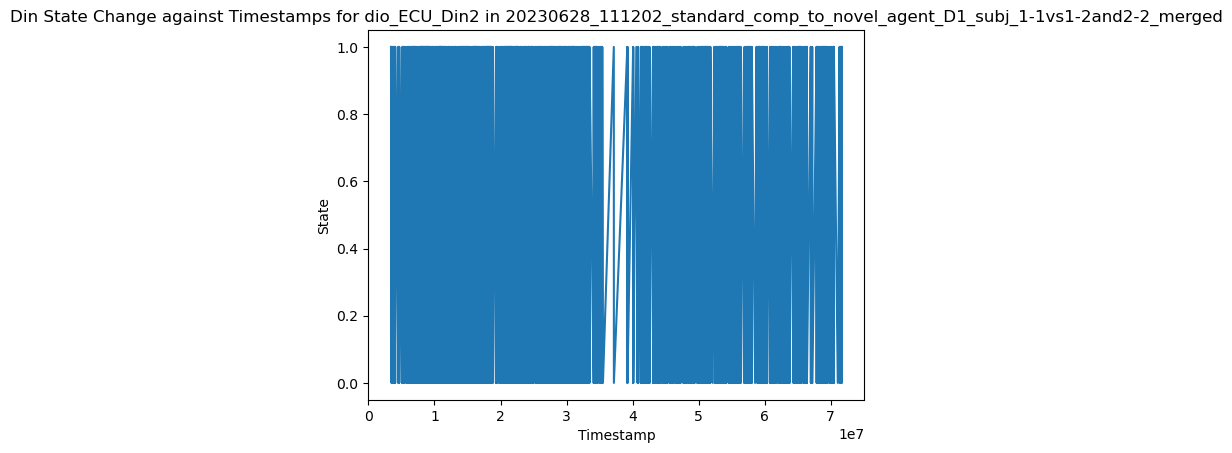

dio_ECU_Din4


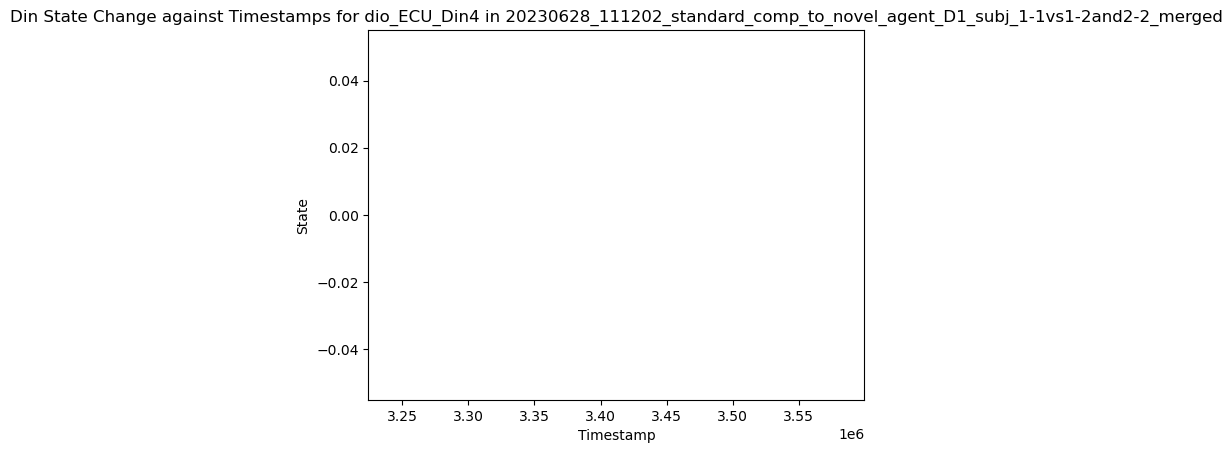

dio_ECU_Din1


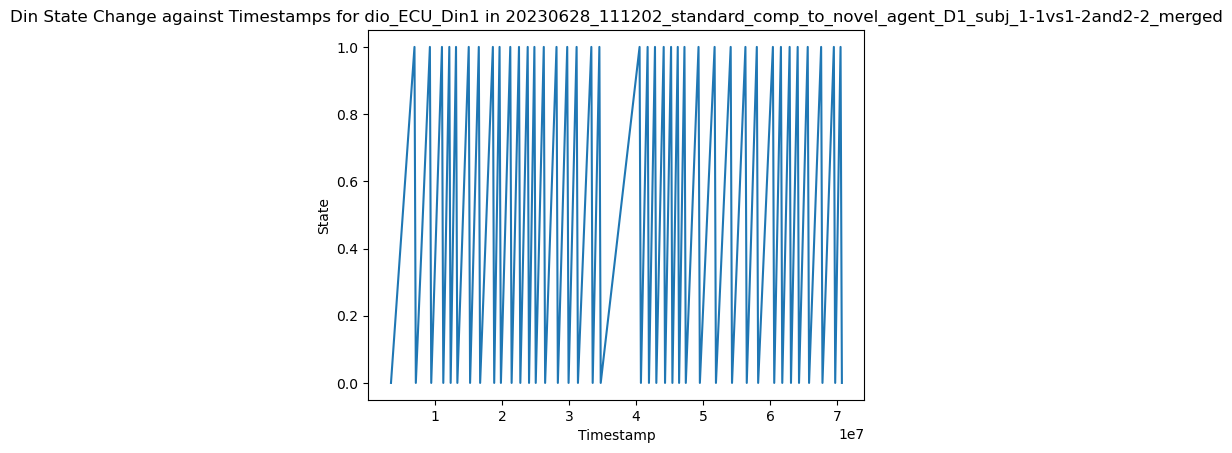

dio_ECU_Din3


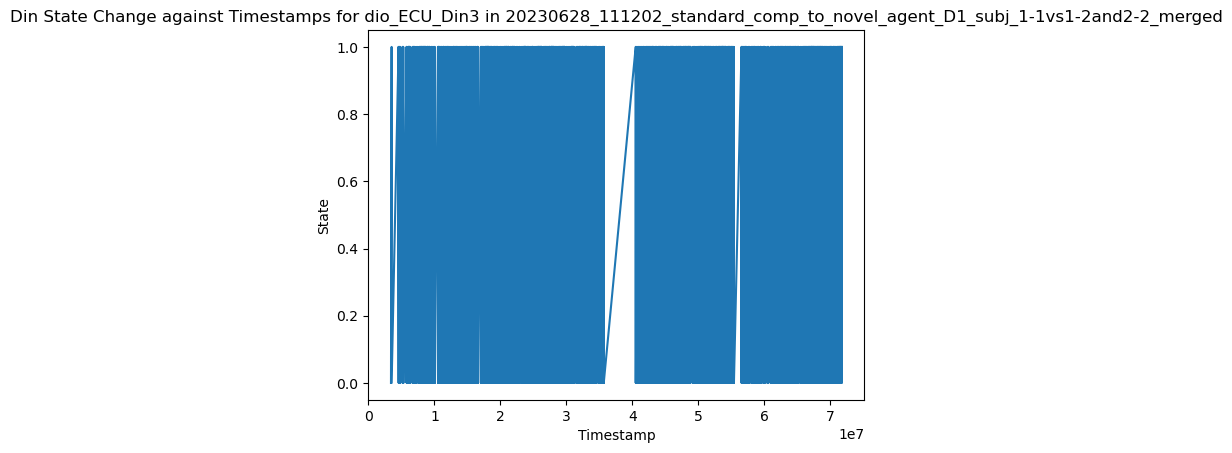

20230614_114041_standard_comp_to_training_D3_subj_1-2_t2b2L_box2_merged
dio_ECU_Din2


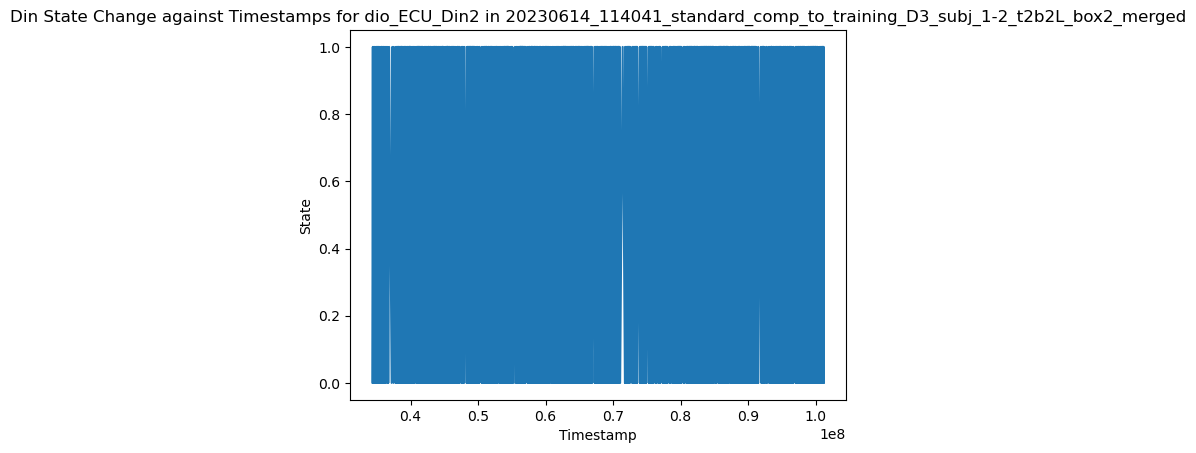

dio_ECU_Din4


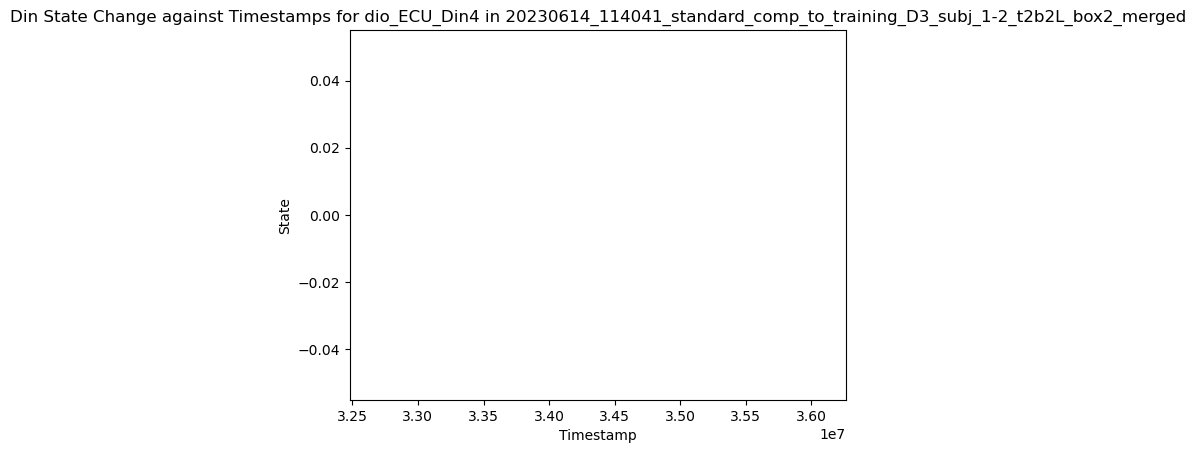

dio_ECU_Din3


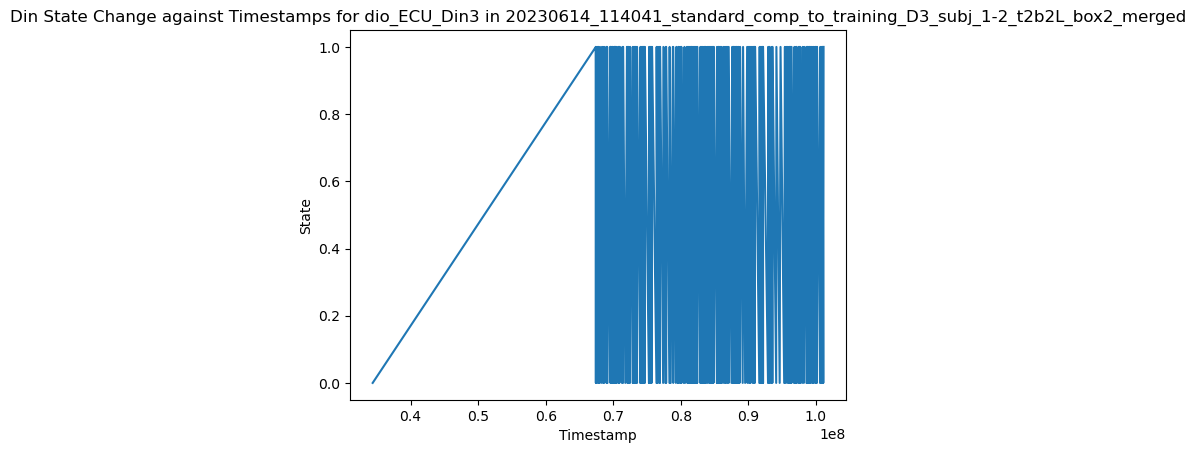

dio_ECU_Din1


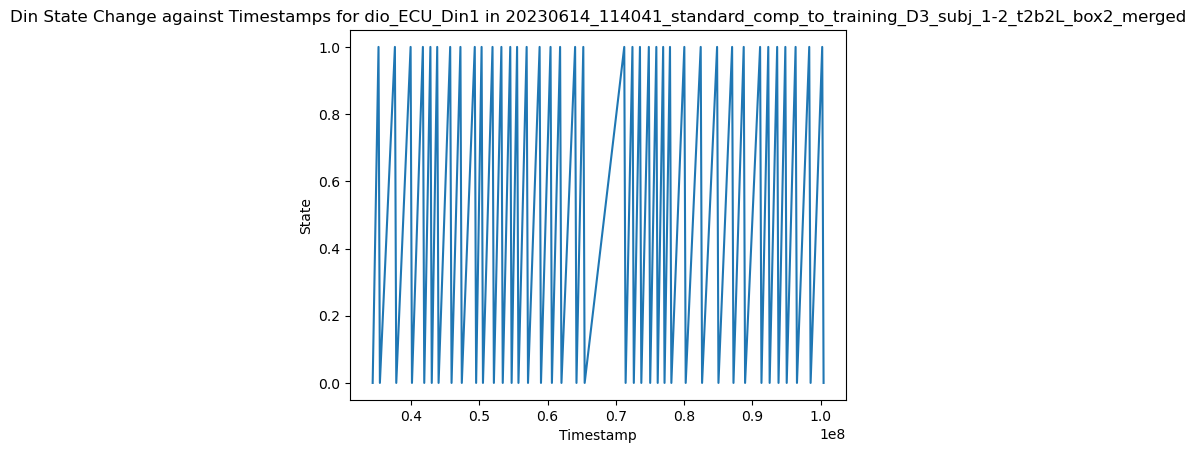

20230614_114041_standard_comp_to_training_D3_subj_1-1_t1b3L_box1_merged
dio_ECU_Din3


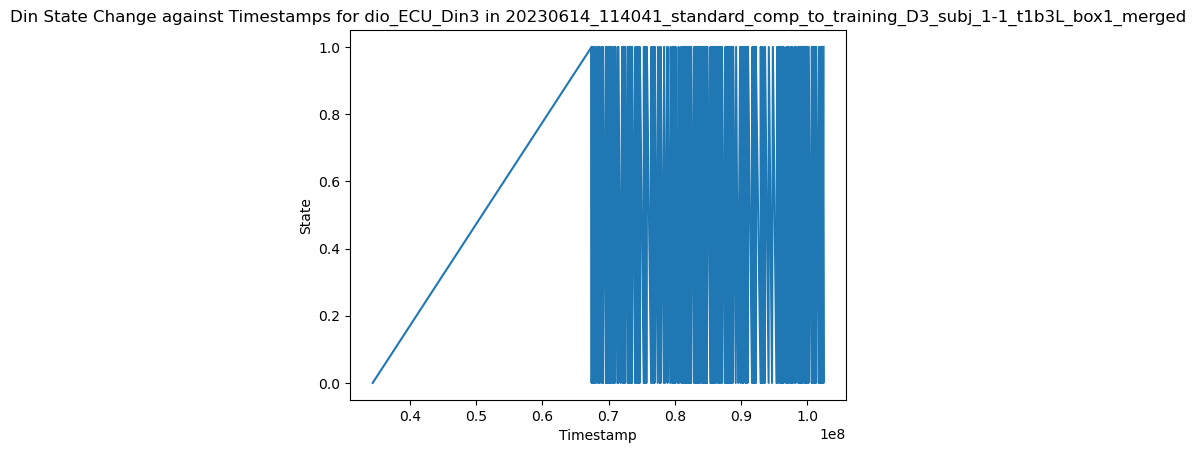

dio_ECU_Din4


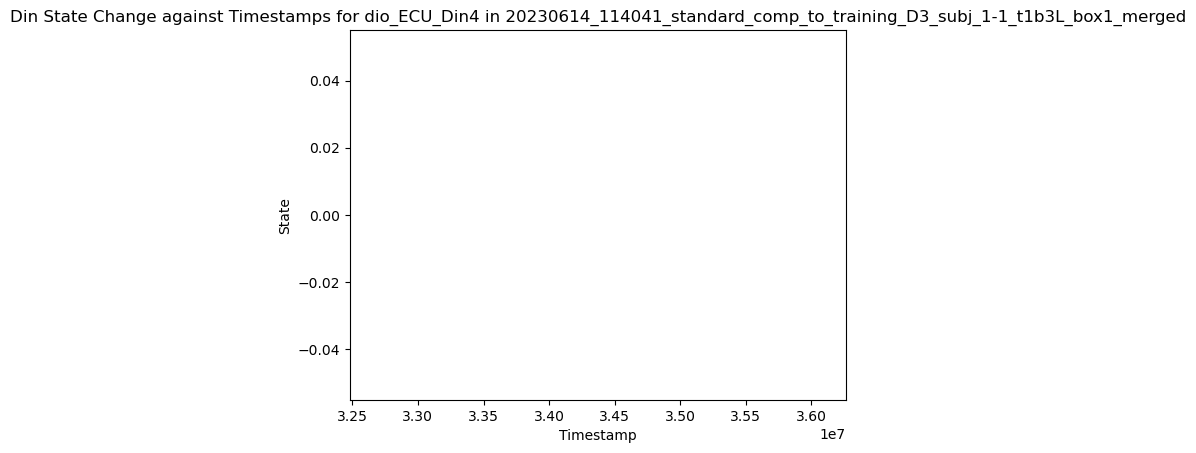

dio_ECU_Din2


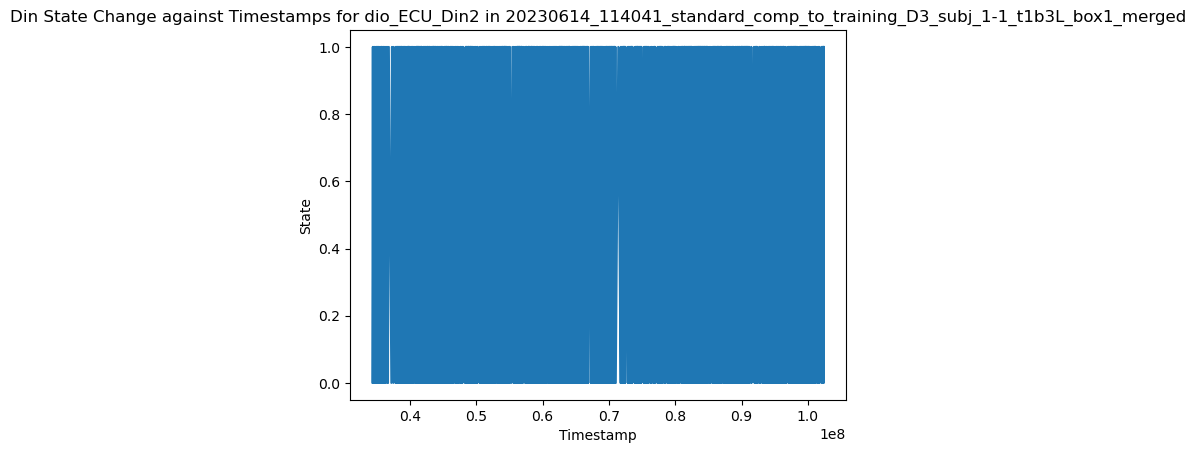

dio_ECU_Din1


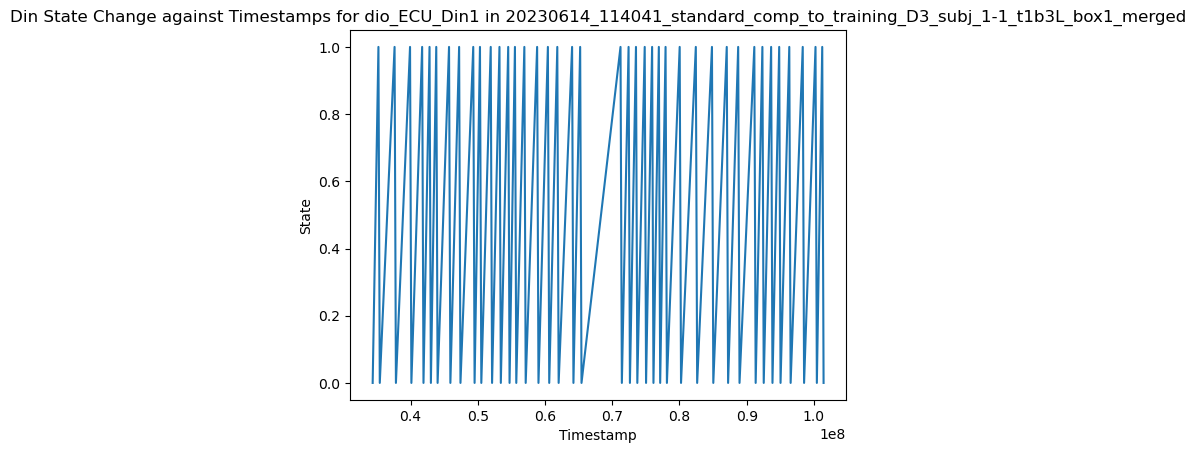

ValueError: No objects to concatenate

In [12]:
session_to_din_state_df = {}
for session, file_to_data in session_to_dir.items():
    all_recording_din_state_df = []
    for recording_name, subdir_dict in file_to_data.items():
        print(recording_name)
        current_recording_din_state_df = []

        try:
            voltage_timestamp_array = file_to_data[recording_name]["raw"]["timestamps"]["data"]
            for key, value in file_to_data[recording_name]["DIO"].items():
                if "in" in key:
                    print(key)
                    din_state_array = file_to_data[recording_name]["DIO"][key]["data"]
                    current_din_state_df = pd.DataFrame(din_state_array)
                    current_din_state_df["recording_path"] = session_to_path[session]
                    current_din_state_df["recording_dir"] = session
                    current_din_state_df["recording_file"] = recording_name
                    current_din_state_df["din"] = key
                    current_recording_din_state_df.append(current_din_state_df)
                    plt.plot([tup[0] for tup in din_state_array], [tup[1] for tup in din_state_array])
                    plt.xlabel("Timestamp")
                    plt.ylabel("State")
                    plt.title("Din State Change against Timestamps for {} in {}".format(key, recording_name))
                    plt.show()
                    plt.close()
            concatted_per_recording_din_state_df = pd.concat(current_recording_din_state_df).sort_values(by=["recording_file", "din"]).reset_index(drop=True)
            concatted_per_recording_din_state_df["time_stamp_index"] = concatted_per_recording_din_state_df["time"] - voltage_timestamp_array[0][0]
            all_recording_din_state_df.append(concatted_per_recording_din_state_df)
        except Exception as e: 
            print(e)
    concatted_all_recording_din_state_df = pd.concat(all_recording_din_state_df)
    session_to_din_state_df[session] = concatted_all_recording_din_state_df

# LOOP 3 Adding the video timestamps

In [14]:
session_to_din_state_df.keys()

dict_keys(['20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2', '20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs2-1and1-2vs2-2', '20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1', '20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2'])

In [15]:
session_to_din_with_frames_df = {}
for session_path in all_session_files:   
    try:
        session_basename = os.path.splitext(os.path.basename(session_path))[0]
        print("Current Session: {}".format(session_basename))
        file_to_video_timestamps = {}
        for video_timestamps in glob.glob(os.path.join(session_path, "*cameraHWSync")):
            video_basename = os.path.basename(video_timestamps)
            print("Current Video Name: {}".format(video_basename))
            timestamp_array = trodes.read_exported.read_trodes_extracted_data_file(video_timestamps)["data"]["PosTimestamp"]
            file_to_video_timestamps[video_basename] = timestamp_array
            session_to_din_state_df[session_basename][os.path.basename(video_timestamps)] = session_to_din_state_df[session_basename]["time"].apply(lambda x: find_closest_index(sorted_list=timestamp_array, target=x))        
        
        # Find the maximum length of the arrays in the dictionary
        max_length = max(map(len, file_to_video_timestamps.values()))
        
        # Pad each array with NaN values to make them all the same length
        padded_data = {k: np.pad(v, (0, max_length - len(v)), mode='constant', constant_values=np.nan) for k, v in file_to_video_timestamps.items()}
        
        # Convert the padded data to a dataframe
        session_to_din_with_frames_df[session_basename] = pd.DataFrame(padded_data)
        session_to_din_with_frames_df[session_basename].to_csv(os.path.join(OUTPUT_DIR, "{}.frame_to_timestamps.csv".format(session_basename)))
    except Exception as e: 
        print(e)

Current Session: 20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2
Current Video Name: 20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2.2.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Current Video Name: 20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2.1.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]
/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype

Current Session: 20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs2-1and1-2vs2-2
Current Video Name: 20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs2-1and1-2vs2-2.2.videoTimeStamps.cameraHWSync
Current Video Name: 20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs2-1and1-2vs2-2.1.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]


Current Session: 20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1
Current Video Name: 20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1.1.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Current Video Name: 20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1.3.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Current Video Name: 20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1.4.videoTimeStamps.cameraHWSync
Current Video Name: 20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1.2.videoTimeStamps.cameraHWSync
Current Session: 20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2
Current Video Name: 20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.3.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)
/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_p

Current Video Name: 20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.2.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Current Video Name: 20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]


Current Session: 20230614_115827_standard_comp_to_training_D3_subj_2-1_and_2-4
Current Video Name: 20230614_115827_standard_comp_to_training_D3_subj_2-1_and_2-4.2.videoTimeStamps.cameraHWSync
'20230614_115827_standard_comp_to_training_D3_subj_2-1_and_2-4'
Current Session: 20230613_110126_standard_comp_to_training_D2_subj_2-4_and_2-2
Current Video Name: 20230613_110126_standard_comp_to_training_D2_subj_2-4_and_2-2.2.videoTimeStamps.cameraHWSync
'20230613_110126_standard_comp_to_training_D2_subj_2-4_and_2-2'
Current Session: 20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4
Current Video Name: 20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1.videoTimeStamps.cameraHWSync
'20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4'
Current Session: 20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3
Current Video Name: 20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.2.videoTimeStamps.cameraHWSync
'20230612_101430_standard_comp_to_traini

/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


'20230617_115521_standard_comp_to_omission_D1_subj_1-1_and_1-2'
Current Session: 20230617_115641_standard_comp_to_omission_D1_subj_2-2_and_2-4
Current Video Name: 20230617_115641_standard_comp_to_omission_D1_subj_2-2_and_2-4.4.videoTimeStamps.cameraHWSync
'20230617_115641_standard_comp_to_omission_D1_subj_2-2_and_2-4'
Current Session: 20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2
Current Video Name: 20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2.2.videoTimeStamps.cameraHWSync
'20230621_111240_standard_comp_to_omission_D5_subj_1-4_and_1-2'
Current Session: 20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1
Current Video Name: 20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1.2.videoTimeStamps.cameraHWSync
'20230620_114347_standard_comp_to_omission_D4_subj_1-2_and_1-1'
Current Session: 20230618_100646_standard_comp_to_omission_D2_subj_2-4_and_2-1
Current Video Name: 20230618_100646_standard_comp_to_omission_D2_subj_2-4_and_2-1.1.video

In [16]:
session_to_din_state_df["20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2"]

,time,state,recording_path,recording_dir,recording_file,din,time_stamp_index,20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2.2.videoTimeStamps.cameraHWSync,20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2.1.videoTimeStamps.cameraHWSync
0,10693370,0,/scratch/back_up/reward_competition_extention/...,20230629_111937_standard_comp_to_novel_agent_D...,20230629_111937_standard_comp_to_novel_agent_D...,dio_ECU_Din1,0,0,0
1,11812814,1,/scratch/back_up/reward_competition_extention/...,20230629_111937_standard_comp_to_novel_agent_D...,20230629_111937_standard_comp_to_novel_agent_D...,dio_ECU_Din1,1119444,1118,1118
2,12012817,0,/scratch/back_up/reward_competition_extention/...,20230629_111937_standard_comp_to_novel_agent_D...,20230629_111937_standard_comp_to_novel_agent_D...,dio_ECU_Din1,1319447,1317,1317
3,14212844,1,/scratch/back_up/reward_competition_extention/...,20230629_111937_standard_comp_to_novel_agent_D...,20230629_111937_standard_comp_to_novel_agent_D...,dio_ECU_Din1,3519474,3513,3513
4,14412846,0,/scratch/back_up/reward_competition_extention/...,20230629_111937_standard_comp_to_novel_agent_D...,20230629_111937_standard_comp_to_novel_agent_D...,dio_ECU_Din1,3719476,3713,3712
...,...,...,...,...,...,...,...,...,...
6636,78547444,1,/scratch/back_up/reward_competition_extention/...,20230629_111937_standard_comp_to_novel_agent_D...,20230629_111937_standard_comp_to_novel_agent_D...,dio_ECU_Din3,67854074,69217,69297
6637,78548847,0,/scratch/back_up/reward_competition_extention/...,20230629_111937_standard_comp_to_novel_agent_D...,20230629_111937_standard_comp_to_novel_agent_D...,dio_ECU_Din3,67855477,69218,69298
6638,78686446,1,/scratch/back_up/reward_competition_extention/...,20230629_111937_standard_comp_to_novel_agent_D...,20230629_111937_standard_comp_to_novel_agent_D...,dio_ECU_Din3,67993076,69356,69436
6639,78703646,0,/scratch/back_up/reward_competition_extention/...,20230629_111937_standard_comp_to_novel_agent_D...,20230629_111937_standard_comp_to_novel_agent_D...,dio_ECU_Din3,68010276,69373,69453


# LOOP 4: Combining the video columns

In [17]:
session_to_tone_stamp_df = {}
for session, timestamps_df in session_to_din_state_df.items():
    current_timestamps_df = timestamps_df[(timestamps_df["din"] == TONE_DIN) & (timestamps_df["state"] == TONE_STATE)].reset_index(drop=True)
    camera_col = [col for col in current_timestamps_df.columns if "cameraHWSync" in col]
    id_col = [col for col in current_timestamps_df.columns if "cameraHWSync" not in col]
    
    current_timestamps_df = current_timestamps_df.melt(id_vars=id_col, value_vars=camera_col, var_name='video_file', value_name='video_frame')
    current_timestamps_df["video_number"] = current_timestamps_df["video_file"].apply(lambda x: x.strip("videoTimeStamps.cameraHWSync").split(".")[-1])
    current_timestamps_df["subject_info"] = current_timestamps_df["recording_file"].apply(lambda x: x.split("subj")[-1].strip("merged").strip("_"))
    current_timestamps_df["condition"] = np.nan
    session_to_tone_stamp_df[session]  = current_timestamps_df

In [18]:
session_to_tone_stamp_df[session]

,time,state,recording_path,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition
0,35230678,1,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din1,856955,20230614_114041_standard_comp_to_training_D3_s...,0,3,1-2_t2b2L_box2,NaN
1,37630681,1,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din1,3256958,20230614_114041_standard_comp_to_training_D3_s...,0,3,1-2_t2b2L_box2,NaN
2,39930677,1,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din1,5556954,20230614_114041_standard_comp_to_training_D3_s...,0,3,1-2_t2b2L_box2,NaN
3,41730676,1,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din1,7356953,20230614_114041_standard_comp_to_training_D3_s...,0,3,1-2_t2b2L_box2,NaN
4,42830676,1,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din1,8456953,20230614_114041_standard_comp_to_training_D3_s...,0,3,1-2_t2b2L_box2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
232,94830651,1,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din1,60456928,20230614_114041_standard_comp_to_training_D3_s...,44208,1,1-1_t1b3L_box1,NaN
233,96330652,1,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din1,61956929,20230614_114041_standard_comp_to_training_D3_s...,44208,1,1-1_t1b3L_box1,NaN
234,98330651,1,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din1,63956928,20230614_114041_standard_comp_to_training_D3_s...,44208,1,1-1_t1b3L_box1,NaN
235,100230651,1,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din1,65856928,20230614_114041_standard_comp_to_training_D3_s...,44208,1,1-1_t1b3L_box1,NaN


In [19]:
concatenated_tone_stamp_df = pd.concat(session_to_tone_stamp_df.values()).reset_index(drop=True)

In [20]:
concatenated_tone_stamp_df.head()

,time,state,recording_path,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info,condition
0,11812814,1,/scratch/back_up/reward_competition_extention/...,20230629_111937_standard_comp_to_novel_agent_D...,20230629_111937_standard_comp_to_novel_agent_D...,dio_ECU_Din1,1119444,20230629_111937_standard_comp_to_novel_agent_D...,1118,2,1-1v1-4and2-1,NaN
1,14212844,1,/scratch/back_up/reward_competition_extention/...,20230629_111937_standard_comp_to_novel_agent_D...,20230629_111937_standard_comp_to_novel_agent_D...,dio_ECU_Din1,3519474,20230629_111937_standard_comp_to_novel_agent_D...,3513,2,1-1v1-4and2-1,NaN
2,16512872,1,/scratch/back_up/reward_competition_extention/...,20230629_111937_standard_comp_to_novel_agent_D...,20230629_111937_standard_comp_to_novel_agent_D...,dio_ECU_Din1,5819502,20230629_111937_standard_comp_to_novel_agent_D...,5809,2,1-1v1-4and2-1,NaN
3,18312900,1,/scratch/back_up/reward_competition_extention/...,20230629_111937_standard_comp_to_novel_agent_D...,20230629_111937_standard_comp_to_novel_agent_D...,dio_ECU_Din1,7619530,20230629_111937_standard_comp_to_novel_agent_D...,7606,2,1-1v1-4and2-1,NaN
4,19412911,1,/scratch/back_up/reward_competition_extention/...,20230629_111937_standard_comp_to_novel_agent_D...,20230629_111937_standard_comp_to_novel_agent_D...,dio_ECU_Din1,8719541,20230629_111937_standard_comp_to_novel_agent_D...,8703,2,1-1v1-4and2-1,NaN


In [21]:
concatenated_tone_stamp_df.to_csv(os.path.join(OUTPUT_DIR, "{}_tone_timestamp.csv".format(OUTPUT_PREFIX)))

In [22]:
concatted_all_recording_din_state_df

,time,state,recording_path,recording_dir,recording_file,din,time_stamp_index,20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.3.videoTimeStamps.cameraHWSync,20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.2.videoTimeStamps.cameraHWSync,20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1.videoTimeStamps.cameraHWSync
0,34373723,0,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din1,0,0,0,0
1,35230678,1,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din1,856955,0,1067,854
2,35430680,0,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din1,1056957,0,1317,1055
3,37630681,1,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din1,3256958,0,4059,3250
4,37830676,0,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din1,3456953,0,4307,3449
...,...,...,...,...,...,...,...,...,...,...
3877,102267449,0,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din3,67893726,23391,75646,44208
3878,102288646,1,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din3,67914923,23412,75667,44208
3879,102419249,0,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din3,68045526,23543,75798,44208
3880,102437649,1,/scratch/back_up/reward_competition_extention/...,20230614_114041_standard_comp_to_training_D3_s...,20230614_114041_standard_comp_to_training_D3_s...,dio_ECU_Din3,68063926,23561,75817,44208


# Saving the video timestamps

In [23]:
for session_path in all_session_files:   
    try:
        session_basename = os.path.splitext(os.path.basename(session_path))[0]
        print("Current Session: {}".format(session_basename))
        file_to_video_timestamps = {}
        for video_timestamps in glob.glob(os.path.join(session_path, "*cameraHWSync")):
            video_basename = os.path.basename(video_timestamps)
            print("Current Video Name: {}".format(video_basename))
            timestamp_array = trodes.read_exported.read_trodes_extracted_data_file(video_timestamps)["data"]["PosTimestamp"]
            file_to_video_timestamps[video_basename] = timestamp_array
            session_to_din_state_df[session_basename][os.path.basename(video_timestamps)] = session_to_din_state_df[session_basename]["time"].apply(lambda x: find_closest_index(sorted_list=timestamp_array, target=x))        
        
        # Find the maximum length of the arrays in the dictionary
        max_length = max(map(len, file_to_video_timestamps.values()))
        
        # Pad each array with NaN values to make them all the same length
        padded_data = {k: np.pad(v, (0, max_length - len(v)), mode='constant', constant_values=np.nan) for k, v in file_to_video_timestamps.items()}
        
        # Convert the padded data to a dataframe
        session_to_din_with_frames_df[session_basename] = pd.DataFrame(padded_data)
        session_to_din_with_frames_df[session_basename].to_csv(os.path.join(OUTPUT_DIR, "{}.frame_to_timestamps.csv".format(session_basename)))
    except Exception as e: 
        print(e)

Current Session: 20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2
Current Video Name: 20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2.2.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Current Video Name: 20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2.1.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]
/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype

Current Session: 20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs2-1and1-2vs2-2
Current Video Name: 20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs2-1and1-2vs2-2.2.videoTimeStamps.cameraHWSync
Current Video Name: 20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs2-1and1-2vs2-2.1.videoTimeStamps.cameraHWSync


/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]
/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Current Session: 20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1
Current Video Name: 20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1.1.videoTimeStamps.cameraHWSync
Current Video Name: 20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1.3.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Current Video Name: 20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1.4.videoTimeStamps.cameraHWSync
Current Video Name: 20230628_111202_standard_comp_to_novel_agent_D1_subj_1-1vs2-2and1-2vs2-1.2.videoTimeStamps.cameraHWSync
Current Session: 20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2
Current Video Name: 20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.3.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)
/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_p

Current Video Name: 20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.2.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Current Video Name: 20230614_114041_standard_comp_to_training_D3_subj_1-1_and_1-2.1.videoTimeStamps.cameraHWSync


/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]


Current Session: 20230614_115827_standard_comp_to_training_D3_subj_2-1_and_2-4
Current Video Name: 20230614_115827_standard_comp_to_training_D3_subj_2-1_and_2-4.2.videoTimeStamps.cameraHWSync
'20230614_115827_standard_comp_to_training_D3_subj_2-1_and_2-4'
Current Session: 20230613_110126_standard_comp_to_training_D2_subj_2-4_and_2-2
Current Video Name: 20230613_110126_standard_comp_to_training_D2_subj_2-4_and_2-2.2.videoTimeStamps.cameraHWSync
'20230613_110126_standard_comp_to_training_D2_subj_2-4_and_2-2'
Current Session: 20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4
Current Video Name: 20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4.1.videoTimeStamps.cameraHWSync
'20230613_105657_standard_comp_to_training_D2_subj_1-1_and_1-4'
Current Session: 20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3
Current Video Name: 20230612_101430_standard_comp_to_training_D1_subj_1-4_and_1-3.2.videoTimeStamps.cameraHWSync
'20230612_101430_standard_comp_to_traini

/nancy/projects/reward_competition_extention/results/2023_08_08_trial_labeling/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


In [24]:
video_to_timestamp = {}
for session_path in all_session_files:   
    try:
        session_basename = os.path.splitext(os.path.basename(session_path))[0]
        print("Current Session: {}".format(session_basename))
        file_to_video_timestamps = {}
        for video_timestamps in glob.glob(os.path.join(session_path, "*cameraHWSync")):
            video_basename = os.path.basename(video_timestamps)
            print("Current Video Name: {}".format(video_basename))
            timestamp_array = trodes.read_exported.read_trodes_extracted_data_file(video_timestamps)["data"]["PosTimestamp"]
            print(video_basename)
            print(timestamp_array)
            video_to_timestamp[video_basename] = timestamp_array
            continue
            file_to_video_timestamps[video_basename] = timestamp_array
            session_to_din_state_df[session_basename][os.path.basename(video_timestamps)] = session_to_din_state_df[session_basename]["time"].apply(lambda x: find_closest_index(sorted_list=timestamp_array, target=x))
            break
        continue
        # Find the maximum length of the arrays in the dictionary
        max_length = max(map(len, file_to_video_timestamps.values()))
        
        # Pad each array with NaN values to make them all the same length
        padded_data = {k: np.pad(v, (0, max_length - len(v)), mode='constant', constant_values=np.nan) for k, v in file_to_video_timestamps.items()}
        
        # Convert the padded data to a dataframe
        session_to_din_with_frames_df[session_basename] = pd.DataFrame(padded_data)
        session_to_din_with_frames_df[session_basename].to_csv(os.path.join(OUTPUT_DIR, "{}.frame_to_timestamps.csv".format(session_basename)))
    except Exception as e: 
        print(e)

Current Session: 20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2
Current Video Name: 20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2.2.videoTimeStamps.cameraHWSync
20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2.2.videoTimeStamps.cameraHWSync
[10693368 10694754 10694754 ... 79131765 79131765 79133151]
Current Video Name: 20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2.1.videoTimeStamps.cameraHWSync
20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2.1.videoTimeStamps.cameraHWSync
[10693368 10694754 10694754 ... 79131765 79133151 79133151]
Current Session: 20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs2-1and1-2vs2-2
Current Video Name: 20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs2-1and1-2vs2-2.2.videoTimeStamps.cameraHWSync
20230630_115506_standard_comp_to_novel_agent_D3_subj_1-4vs2-1and1-2vs2-2.2.videoTimeStamps.cameraHWSync
[10971928 109719

In [27]:
session_to_din_with_frames_df

{'20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2':        20230629_111937_standard_comp_to_novel_agent_D2_subj_1-1vs2-1and1-4vs2-2.2.videoTimeStamps.cameraHWSync  \
 0                                               10693368                                                         
 1                                               10694754                                                         
 2                                               10694754                                                         
 3                                               10696140                                                         
 4                                               10697526                                                         
 ...                                                  ...                                                         
 69878                                                  0                                                         
 698